In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

### Synaptic conductance model to simulate an EPSP

In [2]:
def epsp(c_m=1, g_l=1, tau_syn=1, E_syn=10, delta_t=0.01):
    """
    Calculates the EPSP over time using integration by Euler's scheme.
    
    Parameters:
    c_m (float): capacitance of the membrane
    g_l (float): conductance of the leakage channel
    tau_syn (float): time constant which sets the openning of the synaptic ion channel
    E_syn (float): reversal potantial of the synaptic ion channel
    delta_t (float): Euler's scheme integration time step in ms.
    """
    g_syn = [0] # Concuctance of the synaptic ion channel. Initially 0, meaning the channel is close.
    I_syn = [0] # The synaptic ion channel current. Also 0 initially, as the channel is closed.
    v_m = [0] # Membrane potential. Initially 0.
    t = [0] # Time index.
    
    for _ in range(int(10/delta_t)):
        t.append(t[-1] + delta_t)
        if abs(t[-1] - 1) < 0.001: g_syn[-1] = 1 # Handles the small absolute differences which can screw up the calculations.
        
        # dg_syn/dt = 1/tau_syn * (-g_syn + delta_t).
        g_syn.append(g_syn[-1] - delta_t/tau_syn * g_syn[-1])
        
        # Ohms law: g*V
        I_syn.append(g_syn[-1] * (v_m[-1] - E_syn))
        
        # dv_m/dt = -I/cm. There are two currents here which sum up due to Kirkhoffs law.
        v_m.append(v_m[-1] - delta_t/c_m * g_l * v_m[-1] - delta_t/c_m * I_syn[-1])
    
    g_syn, I_syn, v_m, t = np.array(g_syn), np.array(I_syn), np.array(v_m), np.array(t)
    
    # Plot the functions.
    plt.plot(t, v_m, label='Membrane potential')
    plt.plot(t, g_syn*5, '--', label='Conductance of synaptic ion channel.')
    plt.plot(t, I_syn/5, ':', label='Current of synaptic ion channel.')
    
    ax = plt.gca()
    ax.legend()
    ax.set_xlabel('t (ms)')

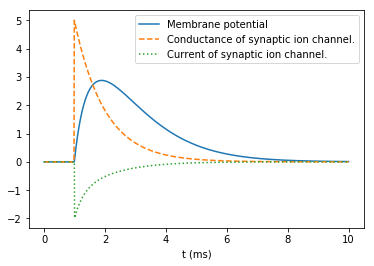

In [3]:
epsp(c_m=1, g_l=1)

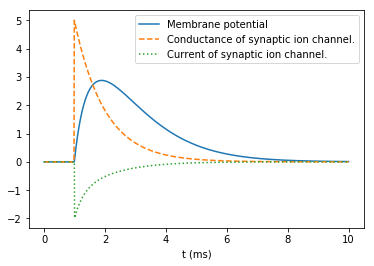

In [4]:
epsp(c_m=1, g_l=1, E_syn=10, delta_t=0.01)

Notes: 

* Only membrane potential v_m depends on the capacitance of the membrane c_m.
* Longer tau_syn, the delay for openning the ion channels, influences longer duration of the current. This means that different channels will have different impulse durations.  
* Only membrane potential v_m depends on the conductance of the leakage channel. 

### Hodgkin-Huxley equations

In [5]:
def hh(gK=36, gNa=120, gK2=0.3, En=-12, Em=115, Eh=10.613, delta_t=0.01, 
       V_0=-10, I_ext_on=10, t_max=50, t_on=10, t_off=40):
    """
    Integrates Hodgkin-Huxley equations for neuron action potential using Euler's scheme.
    Hodgkin and Huxley originally used this model to simulate the axon of a giant squid.
    
    The key part of the model is introduction of three voltage and time dependent variables: 
    - n: activation of voltage-gated potassium channels
    - m: activation of voltage-gated sodium channels
    - h: inactivation of the voltage-gated potassium channels.
    (See page 34 of the book for more details about the model)
    
    Parameters:
    gK (float): Maximal conductance of potassium channel (mS/cm^2)
    gNa (float): Maximal conductance of sodium channel (mS/cm^2)
    gK2 (float): Maximal conductance of second potassium channel (mS/cm^2)
    En (float): Battery voltage for sodium channel (mV)
    En (float): Battery voltage for sodium channel (mV)
    Em, Eh (float): Battery voltages for potassium channel (mV)
    delta_t (float): Time step for integration (ms)
    V_0 (float): Initial membrane potential (mV)
    I_ext (float): External current (mA/cm^2)
    t_max (int): The time to stop the simulation (ms)
    t_on (int): Time at which to turn external current on (ms)
    t_off (int): Time at which to turn external current off (ms)
    """
    I_ext = 0
    V = V_0 # Membrane potential (mV)
    x = np.zeros(3); x[-1] = 1
    
    E = np.array([En, Em, Eh])
    
    # Arrays of values to plot.
    t_plot = []
    V_plot = []
    
    for t in np.arange(-50, t_max, delta_t):
        if np.isclose(t, t_on, atol=delta_t * 1e-1): I_ext = I_ext_on # Turn current on at 10 ms. Also handle small numerical errors.
        if np.isclose(t, t_off, atol=delta_t * 1e-1): I_ext = 0 # Turn current off at 0 ms.
        
        # Alpha and beta functions are used to calculate x_0 and tau_X_0 variables (replace x with n,m or h.)
        alpha_1 = (10 - V) / (100 * (np.exp((10 - V) / 10) - 1))
        alpha_2 = (25 - V) / (10 * (np.exp((25 - V) / 10) - 1))
        alpha_3 = 0.07 * np.exp(-V/20)
        
        alpha_1 = 0 if V == 10 else alpha_1
        alpha_2 = 0 if V == 25 else alpha_2
        
        beta_1 = 0.125 * np.exp(-V / 80)
        beta_2 = 4 * np.exp(-V / 18)
        beta_3 = 1 / (np.exp((30 - V) / 10) + 1)
        
        alpha = np.array([alpha_1, alpha_2, alpha_3])
        beta = np.array([beta_1, beta_2, beta_3])
        
        tau = 1 / (alpha + beta)
        x_0 = alpha * tau
        
        x = (1 - delta_t / tau) * x + delta_t / tau * x_0
        
        # Calculate the conductances for n, m and h channels.
        gn = gK * x[0]**4.
        gm = gNa * x[1]**3. * x[2]
        gh = gK2
        
        gs = np.array([gn, gm, gh])
        
        # Ohm's law
        I = gs * (V - E)
        
        # Update voltage of membrane.
        V = V + delta_t * (I_ext - sum(I))
        
        if t >= 0:
            t_plot.append(t)
            V_plot.append(V)
            
    plt.plot(t_plot, V_plot)
    plt.gca().set_xlabel('Time (ms)')
    plt.gca().set_ylabel('Membrane potential (mV)')

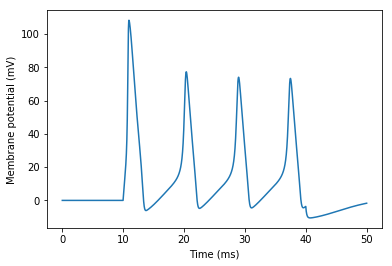

In [9]:
hh(I_ext_on=50, t_off=40, t_max=50)

Notes:

* Since sodium channels, whose openning is the cause of increased membrane potential in a neuron, cannot open for another 1 ms after the previous openning, we get an upper bount on the firing rate of a neuron of about 1000 Hz. This firing rate is, however, not found in practice; it's usually much less. Some neurons have a rate of 600 Hz, but most of them are much lower. This cannot be explained by sodium channels only. Other factors do exist, such as PSP's, non-constant external current, multiple inputs from multiple neurons etc.
* The higher the external current, the larger the firing rate.
* The firing rate function dependent on the external current tends to get linearized and look like a __sigmoid function__ when high frequency (1000 Hz) Gaussian noise is added. This Gaussian noise can come from multiple low frequency inputs from presynaptic neurons. 

### The Wilson Model

In [5]:
from scipy import integrate

from functools import partial

In [32]:
def get_params(external_on=True):
    '''
    Defines the parameters for the model. 
    Use it to fetch those parameters in subsequent code.
    
    The parameters are specified for the ion channels used in the textbook simulation:
    K, Ca, KCa and Na.
    '''
    
    # Maximal conductances for ion channels.
    g_K = 26
    g_Ca = 2.25
    g_KCa = 9.5
    g_Na = 1
    
    # Reversal potentials of the channels.
    E_K = -.95
    E_Ca = 1.20
    E_KCa = E_K
    E_Na = .50
    
    # Time constants for the opennings of the non-leakage channels.
    tau_Ca = 1/4.2
    tau_KCa = 1/15
    tau_Na = 1/45
    
    # External current.
    I_ext = 1 if external_on else 0
    
    g = np.array([g_K, g_Ca, g_KCa, g_Na])
    E = np.array([E_K, E_Ca, E_KCa, E_Na])
    tau = np.array([tau_Ca, tau_KCa, tau_Na])
    
    return g, E, tau, I_ext

def wilson_ode(t, y, external_on=True):
    '''
    Outputs ODE's used by the solver.
    
    y (np.array): An array of R_0, T_0, 
    '''
    g, E, tau, I_ext = get_params(external_on)
    
    V = y[3]
    y3 = y[:3]
    
    x0 = np.array(
        [
            1.24 + 3.7*V + 3.2*V**2, # R
            4.205 + 11.6*V + 8*V**2, # T
            3*y[1] # H
        ]
    )
    
    y_bar3 = tau * (x0 - y3) # Derivatives of R, T and H.
    
    g_Na = 17.8 + 47.6*V + 33.8*V**2
    y3 = np.concatenate([y3, [g_Na]])
    
    I = g*y3*(V - E)
    V_bar = I_ext - I.sum()
    
    y_bar = np.concatenate([y_bar3, [V_bar]]) 
    
    return y_bar
    
def wilson():
    
    # Equilibration: no external input.
    y0 = np.zeros(4)
    y0[-1] = -1
    param = 0
    t_span = (0,100)
    
    wilson_no_ext = partial(wilson_ode, external_on=False)
    
    bunch = integrate.solve_ivp(wilson_no_ext, t_span, y0)
    t,y = bunch.t, bunch.y
    
    # Integration with external input.
    y0 = y[:, -1]
    param = 0
    t_span = (0, 200)
    
    wilson_ext = partial(wilson_ode, external_on=True)
    
    bunch = integrate.solve_ivp(wilson_ext, t_span, y0)
    t,y = bunch.t, bunch.y
    
    V = y[-1, :]
    plt.plot(t, 100*V)
    
    ax = plt.gca()
    
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Membrane potential (mV)')
    

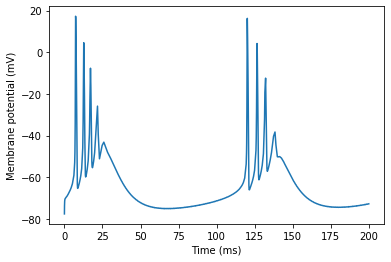

In [33]:
wilson()